In [2]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [4]:
o_outfits= pd.read_csv('./datathon/dataset/outfit_data.csv')
o_product = pd.read_csv('./datathon/dataset/product_data.csv')

outfits = o_outfits.copy()
product = o_product.copy()

In [12]:
def getProduct(idx):
    print("DATOS DEL PRODUCTO")
    print(product.iloc[idx])
    print('APPEARING IN:')
    code = product.iloc[idx].cod_modelo_color
    print(list(outfits[outfits.cod_modelo_color==code]['cod_outfit'].unique()))
    print('IMAGE')
    image_path =product.loc[idx]['des_filename']
#     image_path = 'data/images/2019_51030979_07.jpg'
    img = cv2.imread(image_path)
    plt.imshow(img)


DATOS DEL PRODUCTO
cod_modelo_color                                          41085800-02
cod_color_code                                                     02
des_color_specification_esp                                  OFFWHITE
des_agrup_color_eng                                             WHITE
des_sex                                                        Female
des_age                                                         Adult
des_line                                                          SHE
des_fabric                                                    P-PLANA
des_product_category                                          Bottoms
des_product_aggregated_family                     Trousers & leggings
des_product_family                                           Trousers
des_product_type                                             Trousers
des_filename                     datathon/images/2019_41085800_02.jpg
Name: 0, dtype: object
APPEARING IN:
[1769, 1396, 683]
IMAGE


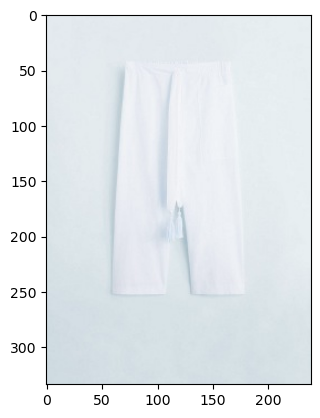

In [13]:
getProduct(0)

In [35]:
product.des_age.value_counts()                                  

des_age
Adult    9112
Kids       19
Name: count, dtype: int64

DATOS DEL PRODUCTO
cod_modelo_color                                          43045777-99
cod_color_code                                                     99
des_color_specification_esp                                     NEGRO
des_agrup_color_eng                                              GREY
des_sex                                                        Female
des_age                                                         Adult
des_line                                                          SHE
des_fabric                                             C-COMPLEMENTOS
des_product_category                    Accesories, Swim and Intimate
des_product_aggregated_family                       Swim and intimate
des_product_family                                           Swimwear
des_product_type                                           Bikini top
des_filename                     datathon/images/2019_43045777_99.jpg
Name: 163, dtype: object
APPEARING IN:
[1824]
IMAGE


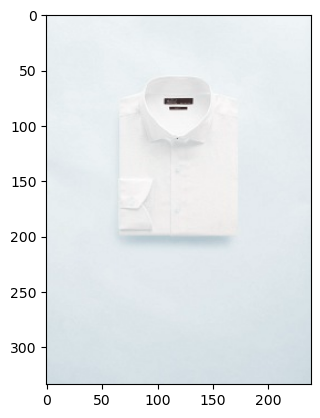

In [29]:
getProduct(162)

## Cleaning data 

In [43]:
#Deleting all the products that are not clothes
product = product[(product.des_product_category!= 'Beauty') & (product.des_product_category!= 'Home')]
# Delete all products for men and kids due to desbalance
product = product[(product.des_line== 'SHE')]
product = product[(product.des_sex== 'Female')]
product = product[(product.des_age== 'Adult')]

product =product.drop(['des_sex','des_line','des_age'], axis = 1)

# Delete the deleted products from outfits
outfits = outfits[outfits.cod_modelo_color.isin(product.cod_modelo_color.unique())]

In [44]:
outfits = outfits[outfits.cod_modelo_color.isin(product.cod_modelo_color.unique())]

In [45]:
product

,cod_modelo_color,cod_color_code,des_color_specification_esp,des_agrup_color_eng,des_fabric,des_product_category,des_product_aggregated_family,des_product_family,des_product_type,des_filename
0,41085800-02,02,OFFWHITE,WHITE,P-PLANA,Bottoms,Trousers & leggings,Trousers,Trousers,datathon/images/2019_41085800_02.jpg
1,53000586-TO,TO,TEJANO OSCURO,BLUE,J-JEANS,Bottoms,Jeans,Jeans,Jeans,datathon/images/2019_53000586_TO.jpg
2,53030601-81,81,ROSA PASTEL,PINK,P-PLANA,"Dresses, jumpsuits and Complete set",Dresses and jumpsuits,Dresses,Dress,datathon/images/2019_53030601_81.jpg
3,53050730-15,15,MOSTAZA,YELLOW,P-PLANA,"Dresses, jumpsuits and Complete set",Dresses and jumpsuits,Dresses,Dress,datathon/images/2019_53050730_15.jpg
4,53070773-70,70,ROJO,RED,P-PLANA,Tops,Shirts,Shirt,Shirt,datathon/images/2019_53070773_70.jpg
...,...,...,...,...,...,...,...,...,...,...
9217,57066027-99,99,NEGRO,GREY,P-PLANA,"Dresses, jumpsuits and Complete set",Dresses and jumpsuits,Dresses,Dress,datathon/images/2023_57066027_99.jpg
9218,57076028-92,92,GRIS,GREY,P-PLANA,Bottoms,Skirts and shorts,Shorts,Shorts,datathon/images/2023_57076028_92.jpg
9219,57068275-05,05,CRUDO,WHITE,C-COMPLEMENTOS,"Accesories, Swim and Intimate",Swim and intimate,Intimate,Socks,datathon/images/2023_57068275_05.jpg
9220,57067125-78,78,BURDEOS,RED,K-CIRCULAR,"Dresses, jumpsuits and Complete set",Dresses and jumpsuits,Dresses,Dress,datathon/images/2023_57067125_78.jpg
